## Initial Local Creation of Bayesian Network

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [29]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators


### Data importing and preprocessing

In [30]:
loaded_data = myData.load_data(num_rows = 500)
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data)

<class 'pandas.core.frame.DataFrame'>


### Structure Learning

In [31]:
scoring_method = estimators.BicScore(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
print(model.nodes())
print(model.edges())

 24%|██▍       | 24/100 [05:04<16:02, 12.67s/it]

['funded_amnt_inv', 'loan_amnt', 'funded_amnt', 'term', 'total_rec_int', 'int_rate', 'grade', 'loan_status', 'out_prncp_inv', 'title', 'purpose', 'fico_range_low', 'fico_range_high', 'open_acc', 'num_sats', 'pub_rec', 'pub_rec_bankruptcies', 'out_prncp', 'total_pymnt_inv', 'total_pymnt', 'last_fico_range_low', 'last_fico_range_high', 'collections_12_mths_ex_med', 'num_tl_90g_dpd_24m', 'delinq_amnt', 'acc_now_delinq', 'num_tl_30dpd', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'tax_liens', 'tot_hi_cred_lim', 'tot_cur_bal', 'home_ownership', 'total_bc_limit', 'total_rev_hi_lim', 'bc_open_to_buy', 'debt_settlement_flag']
[('funded_amnt_inv', 'loan_amnt'), ('funded_amnt_inv', 'funded_amnt'), ('term', 'total_rec_int'), ('term', 'funded_amnt_inv'), ('int_rate', 'grade'), ('loan_status', 'out_prncp_inv'), ('loan_status', 'term'), ('out_prncp_inv', 'out_prncp'), ('title', 'purpose'), ('fico_range_low', 'fico_range_high'), ('open_acc', 'num_sats'), ('pub_rec', 'pub_rec_bankruptcies'), ('total_pym

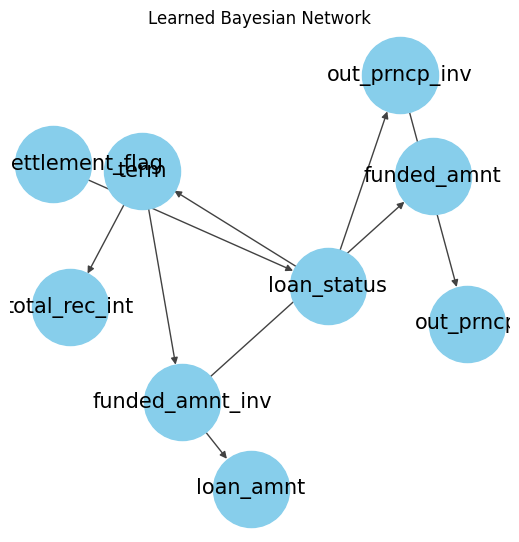

In [32]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(5, 5))
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [33]:
parameter_estimator = estimators.BayesianEstimator(model,train_data)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    print(parameters[i])

+--------------------+----------------------+----------------------+
| term               | term( 36 months)     | term( 60 months)     |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(0) | 0.1934673366834171   | 0.005263157894736842 |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(1) | 0.17336683417085427  | 0.005263157894736842 |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(2) | 0.18341708542713567  | 0.06842105263157895  |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(3) | 0.15326633165829145  | 0.1736842105263158   |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(4) | 0.10301507537688442  | 0.15263157894736842  |
+--------------------+----------------------+----------------------+
| funded_amnt_inv(5) | 0.10301507537688442  | 0.1736842105263158   |
+--------------------+------------